<a href="https://colab.research.google.com/github/KarolChlasta/PJAIT-AdvancedML/blob/master/3.GeneratingWithRNN/syllable-rnn-generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://i.imgur.com/eBRPvWB.png)

##**Generowanie poezji za pomocą RNN i PyTorch sylabami**

[W tutorialu na rozgrzewkę](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) użyliśmy RNN, aby sklasyfikować nazwiska znak po znaku. Tym razem wygenerujemy tekst sylaba po sylabie.
```
Litwo! Ojczyzno moja! ty jesteś klucz wyziemu, 
To opugo cząciły tak lasu czeleta. 
Choć nie będzie mowę świeci się za tém, 
A Dozgon++ na Litwę przerzucił w okolicy, 
Dosyć się opicie przyciągnąć w pałacu; 

Tamdzini nawet mimo osobnych ogórki. 
Choć zwyciętunia, mimo pukle wyślą, 
Odemknął, wbiegł wyszedł, pewnie miłośnik łowił. 
Bo przekorza, i skrobiąc nabój do Warszawy. 
Dość co oddało plecie tak fawował, 
A tam się cukier wytaczać na nich wybująca. 

```

Ok, możesz zadać sobie pytanie, czy ten tutorial jest rzeczywiście praktyczny? Czemu nie? Modele generatywne tego typu stanowią fundament tłumaczenia maszynowego, opisywania obrazów, generowania odpowiedzi na pytania i wielu innych zastowań.

Zobacz [Sequence to Sequence Translation tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb) żeby nauczyć się więcej w tym temacie.

## Polecana lektura

Zakładam, że jest już zainstalowany PyTorch, znasz Python'a, oraz znasz pojęcie Tensor'ów:

* http://pytorch.org/ - instalacja PyTorch
* [Deep Learning with PyTorch: A 60-minute Blitz](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) - Podstawy PyTorch
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) przykłady wykorzystania PyTorch
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) jeżeli znasz Lua Torch

Trochę wiedzy o RNN:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) przykłady z życia wzięte
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) RNN i LSTM w pigułce

Zobacz także podobne tutoriale z serii:

* [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) używa RNN do klasyfikacji
* [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb) opierając się na tym modelu, dodaje kategorię jako dane wejściowe

# Ustawianie środowiska pod syllable-RNN

## Instalacja PyTorch

In [1]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

import torch

     |████████████████████████████████| 484.0MB 2.1MB/s 
ERROR: torchvision 0.4.2 has requirement torch==1.3.1, but you'll have torch 0.4.0 which is incompatible.
ERROR: fastai 1.0.59 has requirement torch>=1.0.0, but you'll have torch 0.4.0 which is incompatible.


## Instalacja bibliotek

In [0]:
!pip install -q scipy --upgrade

In [3]:
!pip install -q unidecode tqdm dill pysmi visdom

     |████████████████████████████████| 245kB 6.5MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 686kB 45.9MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 204kB 34.2MB/s 


## Instalacja biblioteki PyDrive i wrappera

In [0]:
# This only needs to be done once per notebook.
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from pathlib import Path
import os

def download_and_save(file_name, file_id):
  downloaded = drive.CreateFile({'id': file_id})
  # fetch file
  downloaded.FetchContent()
  # write file
  with open(file_name,'wb') as f:
       f.write(downloaded.content.read())
      
  print(f'Saved {file_name}')
  
FILE_NAME, FILE_ID = ['file_name', 'file_id']

## Pobranie i instalacja stemmera

In [5]:
!dpkg --add-architecture i386
!apt-get -qq update
!apt-get -qq install libc6:i386 libncurses5:i386 libstdc++6:i386

Preconfiguring packages ...
Selecting previously unselected package gcc-8-base:i386.
(Reading database ... 145605 files and directories currently installed.)
Preparing to unpack .../0-gcc-8-base_8.3.0-6ubuntu1~18.04.1_i386.deb ...
Unpacking gcc-8-base:i386 (8.3.0-6ubuntu1~18.04.1) ...
Selecting previously unselected package libgcc1:i386.
Preparing to unpack .../1-libgcc1_1%3a8.3.0-6ubuntu1~18.04.1_i386.deb ...
Unpacking libgcc1:i386 (1:8.3.0-6ubuntu1~18.04.1) ...
Selecting previously unselected package libc6:i386.
Preparing to unpack .../2-libc6_2.27-3ubuntu1_i386.deb ...
Unpacking libc6:i386 (2.27-3ubuntu1) ...
Replacing files in old package libc6-i386 (2.27-3ubuntu1) ...
Selecting previously unselected package libtinfo5:i386.
Preparing to unpack .../3-libtinfo5_6.1-1ubuntu1.18.04_i386.deb ...
Unpacking libtinfo5:i386 (6.1-1ubuntu1.18.04) ...
Selecting previously unselected package libncurses5:i386.
Preparing to unpack .../4-libncurses5_6.1-1ubuntu1.18.04_i386.deb ...
Unpacking libncu

In [6]:
# stemmer-2.0.3.tgz, https://drive.google.com/file/d/1PxS-e6tzXa7u4N9A2r9XWLUpvSKqJIrZ
stemmer = {FILE_NAME: 'stemmer-2.0.3.tgz', FILE_ID: '1PxS-e6tzXa7u4N9A2r9XWLUpvSKqJIrZ'}
stemmer_path = Path('./') / stemmer[FILE_NAME]
download_and_save(stemmer_path, stemmer[FILE_ID])

Saved stemmer-2.0.3.tgz


In [0]:
!tar xzf $stemmer_path

In [9]:
ls -lah bin

total 8.2M
drwxr-xr-x 2  501 staff 4.0K Apr 30  2018 ./
drwxr-xr-x 1 root root  4.0K Nov 22 22:43 ../
-rw-r--r-- 1  501 staff 1.2K Apr 19  2018 changelog.txt
-rwxr-xr-x 1  501 staff  629 Jan  2  2018 destem.sh*
-rw-r--r-- 1  501 staff 858K Nov 22  2017 stemmer2.dic
-rwxrwxr-x 1  501 staff 3.7M Apr 19  2018 stemmer.linux*
-rwxr-xr-x 1  501 staff 3.6M Apr 30  2018 stemmer.macos*


# Pobranie danych

In [10]:
from pathlib import Path
dataset_path = Path('/content/data/rnn_generator'); dataset_path
!mkdir -p $dataset_path
!ls -la $dataset_path/
tmp_path = dataset_path / 'tmp/'
!mkdir -p $tmp_path

total 8
drwxr-xr-x 2 root root 4096 Nov 22 22:43 .
drwxr-xr-x 3 root root 4096 Nov 22 22:43 ..


## Pobranie datasetu Pan Tadeusz

In [11]:
# pan_tadeusz, https://drive.google.com/open?id=1l8KGrqUsrGOlXVp7Frgyku8w75X_WA8h
pan_tadeusz = {FILE_NAME: 'pan_tadeusz.txt', FILE_ID: '1l8KGrqUsrGOlXVp7Frgyku8w75X_WA8h'}

download_and_save(dataset_path / pan_tadeusz[FILE_NAME], pan_tadeusz[FILE_ID])

Saved /content/data/rnn_generator/pan_tadeusz.txt


In [12]:
ls -la $dataset_path/

total 232
drwxr-xr-x 3 root root   4096 Nov 22 22:44 ./
drwxr-xr-x 3 root root   4096 Nov 22 22:43 ../
-rw-r--r-- 1 root root 223706 Nov 22 22:44 pan_tadeusz.txt
drwxr-xr-x 2 root root   4096 Nov 22 22:43 tmp/


# Opcjonalne

## Opcjonalne pobranie innych datasetów

In [13]:
# witkacy_szewcy, https://drive.google.com/open?id=1NOWTocYwv93GibItaNBxTJobjTukQmRP
witkacy = {FILE_NAME: 'witkacy_szewcy.txt', FILE_ID: '1NOWTocYwv93GibItaNBxTJobjTukQmRP'}

download_and_save(dataset_path / witkacy[FILE_NAME], witkacy[FILE_ID])

Saved /content/data/rnn_generator/witkacy_szewcy.txt


In [14]:
# mickiewicz, https://drive.google.com/open?id=1otbOB7GjKEVPjaPShaaTnYQnv-whwNWP
mickiewicz = {FILE_NAME: 'mickiewicz.txt', FILE_ID: '1otbOB7GjKEVPjaPShaaTnYQnv-whwNWP'}

download_and_save(dataset_path / mickiewicz[FILE_NAME], mickiewicz[FILE_ID])

Saved /content/data/rnn_generator/mickiewicz.txt


In [15]:
!ls -la $dataset_path/

total 1088
drwxr-xr-x 3 root root   4096 Nov 22 22:44 .
drwxr-xr-x 3 root root   4096 Nov 22 22:43 ..
-rw-r--r-- 1 root root 725495 Nov 22 22:44 mickiewicz.txt
-rw-r--r-- 1 root root 223706 Nov 22 22:44 pan_tadeusz.txt
drwxr-xr-x 2 root root   4096 Nov 22 22:43 tmp
-rw-r--r-- 1 root root 145132 Nov 22 22:44 witkacy_szewcy.txt


## Opcjonalne pobranie przetrenowanego modelu

In [16]:
# all_tokens.n5059.pan_tadeusz.p, https://drive.google.com/open?id=14AxyK--ifqyzwThw712jHid7NVaLqAC3
# pan_tadeusz.h500.l3.20.gpu.torch, https://drive.google.com/open?id=1NF-bmLgsAC6l_Fdlr7xZ1_i3e_5EgIYG
ALLTOKS, MODEL = ['all_tokens', 'model']
fn_pan_tadeusz = {ALLTOKS: 'all_tokens.n5059.pan_tadeusz.p', MODEL: 'pan_tadeusz.h500.l3.e20.gpu.torch'}
ids_pan_tadeusz = {ALLTOKS: '14AxyK--ifqyzwThw712jHid7NVaLqAC3', MODEL: '1NF-bmLgsAC6l_Fdlr7xZ1_i3e_5EgIYG'}
download_and_save(tmp_path / fn_pan_tadeusz[ALLTOKS], ids_pan_tadeusz[ALLTOKS])
download_and_save(tmp_path / fn_pan_tadeusz[MODEL], ids_pan_tadeusz[MODEL])

Saved /content/data/rnn_generator/tmp/all_tokens.n5059.pan_tadeusz.p
Saved /content/data/rnn_generator/tmp/pan_tadeusz.h500.l3.e20.gpu.torch


In [17]:
# all_tokens.n4064.witkacy_szewcy.p, https://drive.google.com/open?id=1hXWaH1vwciJqDh4mRA9R1B6ePapORCTc
# witkacy_szewcy.h500.l3.e11.gpu.torch, https://drive.google.com/open?id=1DegovTSmaNEyFM3AS8JZZnp7STO49IRp
ALLTOKS, MODEL = ['all_tokens', 'model']
fn_pan_tadeusz = {ALLTOKS: 'all_tokens.n4064.witkacy_szewcy.p', MODEL: 'witkacy_szewcy.h500.l3.e11.gpu.torch'}
ids_pan_tadeusz = {ALLTOKS: '1hXWaH1vwciJqDh4mRA9R1B6ePapORCTc', MODEL: '1DegovTSmaNEyFM3AS8JZZnp7STO49IRp'}
download_and_save(tmp_path / fn_pan_tadeusz[ALLTOKS], ids_pan_tadeusz[ALLTOKS])
download_and_save(tmp_path / fn_pan_tadeusz[MODEL], ids_pan_tadeusz[MODEL])

Saved /content/data/rnn_generator/tmp/all_tokens.n4064.witkacy_szewcy.p
Saved /content/data/rnn_generator/tmp/witkacy_szewcy.h500.l3.e11.gpu.torch


In [18]:
ls -lah $tmp_path

total 70M
drwxr-xr-x 2 root root 4.0K Nov 22 22:44 ./
drwxr-xr-x 3 root root 4.0K Nov 22 22:44 ../
-rw-r--r-- 1 root root  63K Nov 22 22:44 all_tokens.n4064.witkacy_szewcy.p
-rw-r--r-- 1 root root  80K Nov 22 22:44 all_tokens.n5059.pan_tadeusz.p
-rw-r--r-- 1 root root  37M Nov 22 22:44 pan_tadeusz.h500.l3.e20.gpu.torch
-rw-r--r-- 1 root root  33M Nov 22 22:44 witkacy_szewcy.h500.l3.e11.gpu.torch


## Opcjonalny monitoring treningu

In [0]:
#!python -m visdom.server -p 8890 -logging_level ERROR

## Opcjonalna konfiguracja integracji z Dyskiem Google



In [19]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive -o nonempty

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145933 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.13-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

# Monitorowanie maszyny wirtualnej

In [20]:
!uptime

 22:46:04 up 17 min,  0 users,  load average: 0.29, 0.29, 0.17


## Załadowanie bibliotek

In [0]:
from pathlib import Path
import platform
import string
import random
import re
from IPython.core.display import display, HTML
import os
import psutil
import pickle
import warnings
import torch
import torch.nn as nn
from torch.autograd import Variable
import time, math
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import matplotlib as mpl
mpl.style.use('default')
mpl.style.use('bmh')


## Preprocessing korpusu

In [0]:
dataset_path = Path('data/rnn_generator'); dataset_path
tmp_path = dataset_path / 'tmp/'
!mkdir -p $tmp_path

In [23]:
ls -lah $dataset_path/

total 1.1M
drwxr-xr-x 3 root root 4.0K Nov 22 22:44 ./
drwxr-xr-x 3 root root 4.0K Nov 22 22:43 ../
-rw-r--r-- 1 root root 709K Nov 22 22:44 mickiewicz.txt
-rw-r--r-- 1 root root 219K Nov 22 22:44 pan_tadeusz.txt
drwxr-xr-x 2 root root 4.0K Nov 22 22:44 tmp/
-rw-r--r-- 1 root root 142K Nov 22 22:44 witkacy_szewcy.txt


In [0]:
fn_corpus_char = dataset_path/'pan_tadeusz.txt'
fn_corpus_caps = dataset_path/'pan_tadeusz.caps1.txt'
fn_corpus_syl = dataset_path/'pan_tadeusz.syl1.txt'

Plik wejściowy (korpus) to duży plik tekstowy. 

In [25]:
!head -n 21 $fn_corpus_char

﻿KSIĘGA PIÉRWSZA.




GOSPODARSTWO.


TREŚĆ.

    Powrot panicza -- Spotkanie się piérwsze w pokoiku, drugie u
    stołu -- Ważna Sędziego nauka o grzeczności -- Podkomorzego uwagi
    polityczne nad modami -- Początek sporu o Kusego i Sokoła -- Żale
    Wojskiego -- Ostatni Woźny Trybunału -- Rzut oka na ówczesny stan
    polityczny Litwy i Europy.


  Litwo! Ojczyzno moja! ty jesteś jak zdrowie;
Ile cię trzeba cenić, ten tylko się dowie
Kto cię stracił. Dziś piękność twą w całéj ozdobie
Widzę i opisuję, bo tęsknię po tobie.


### Tokenizacja wielkich liter

Zamieniamy duże litery na małe dodając tokeny `_up_` (dla wyrazów pisanych wielkimi literami) lub `_cap_` (dla wyrazów pisanych z wielkiej litery).

In [0]:
def do_caps(ss):
  TOK_UP,TOK_CAP = ' _up_ ', ' _cap_ '
  res = []
  re_word = re.compile('\w')
  for s in re.findall(r'\w+|\W+', ss):
      res += ([TOK_UP,s.lower()] if (s.isupper() and (len(s)>2))
              else [TOK_CAP,s.lower()] if s.istitle()
              else [s.lower()])
  return ''.join(res)

In [27]:
corpus_tmp = fn_corpus_char.open('r').read()
corpus_tmp = do_caps(corpus_tmp)
fn_corpus_caps.open('w').write(corpus_tmp)

246668

In [28]:
!head -n 21 $fn_corpus_caps

﻿ _up_ księga  _up_ piérwsza.




 _up_ gospodarstwo.


 _up_ treść.

     _cap_ powrot panicza --  _cap_ spotkanie się piérwsze w pokoiku, drugie u
    stołu --  _cap_ ważna  _cap_ sędziego nauka o grzeczności --  _cap_ podkomorzego uwagi
    polityczne nad modami --  _cap_ początek sporu o  _cap_ kusego i  _cap_ sokoła --  _cap_ żale
     _cap_ wojskiego --  _cap_ ostatni  _cap_ woźny  _cap_ trybunału --  _cap_ rzut oka na ówczesny stan
    polityczny  _cap_ litwy i  _cap_ europy.


   _cap_ litwo!  _cap_ ojczyzno moja! ty jesteś jak zdrowie;
 _cap_ ile cię trzeba cenić, ten tylko się dowie
 _cap_ kto cię stracił.  _cap_ dziś piękność twą w całéj ozdobie
 _cap_ widzę i opisuję, bo tęsknię po tobie.


### Podział korpusu na sylaby

Dzielimy korpus na sylaby programem `stemmer`.

In [0]:
platform_suffixes = {'Linux': 'linux', 'Darwin': 'macos'}
platform_suffix = platform_suffixes[platform.system()]
stemmer_bin = f'LD_PRELOAD="" bin/stemmer.{platform_suffix}'

In [30]:
!$stemmer_bin --help


Stemmer 2.0.3 2018-04-19 (Linux i386)
For Korrida database, spellchecker and hyphenator copyright (C) 1993-2018 Wojciech Czarnowski
For Stemmer copyright (C) 2018 Krzysztof Wolk and Wojciech Czarnowski
Wojciech Czarnowski: wojtek.czarnowski@gmail.com, +48(608)202-272
Krzysztof Wolk: krz.wolk@gmail.com, +48(606)918-623

Usage: stemmer options

Options:
-v, --verbose
--version
-s number, --stem=number
-d file or --dict=<file.dic>
-i file or --file_in=<file>
-o file or --file_out=<file>
-l file or --log=<file>
-e file or --exclude=<file>
--stem_delim="string"
--code_delim="string"
--divide_after=number

Stemming options:
  1 stem "nie" prefix
  2 stem extra prefixes
  4 stem prefixes in root
  8 stem in suffix

POS options:
 16 output POS and inflection group
 32 output additional POS info

Output Korrida codes:
 64 group code
128 base suffix codes
256 suffix code

Division options:
 512 divide words
1024 divide with dictionary
2048 divide algorithmically
4096 divide unknown words

Using 

In [31]:
!$stemmer_bin -s 7683 -v -d bin/stemmer2.dic -i $fn_corpus_caps -o $fn_corpus_syl

Stemmer 2.0.3 2018-04-19 (Linux i386)
For Korrida database, spellchecker and hyphenator copyright (C) 1993-2018 Wojciech Czarnowski
For Stemmer copyright (C) 2018 Krzysztof Wolk and Wojciech Czarnowski
Wojciech Czarnowski: wojtek.czarnowski@gmail.com, +48(608)202-272
Krzysztof Wolk: krz.wolk@gmail.com, +48(606)918-623

Dictionary: "bin/stemmer2.dic"
Input file: "data/rnn_generator/pan_tadeusz.caps1.txt"
Output file: "data/rnn_generator/pan_tadeusz.syl1.txt"
Stem number: "7683"

Stemming options:
  StemNiePrefix     : Yes
  StemExtraPrefixes : Yes
  StemPrefixesInRoot: No

Syllable division options:
  DivideWords          : Yes
  DivideWithDictionary : Yes
  DivideAlgorithmically: Yes
  DivideUknkownWords   : Yes
  divideAfterChar      : 1

Stemming formatting options:
  StemInSuffix       : No
  ShowPOSInfo        : No
  ShowExtraPOSInfo   : No

  ShowGroupCode      : No
  ShowBaseSuffixCodes: No
  ShowSuffixCode     : No

  stemDelimiterStr   : "++ --"
  codeDelimiterStr   : "@@"

Ste

In [32]:
!head -n 21 $fn_corpus_syl

 _up_ księ++ --ga  _up_ pié++ --rwsza.




 _up_ go++ --s++ --po++ --dar++ --stwo.


 _up_ treść.

     _cap_ po++ --wrot pa++ --ni++ --cza --  _cap_ spot++ --ka++ --nie się pié++ --rwsze w po++ --koi++ --ku, dru++ --gie u
    sto++ --łu --  _cap_ waż++ --na  _cap_ sę++ --dzie++ --go na++ --u++ --ka o grze++ --cz++ --no++ --ści --  _cap_ pod++ --ko++ --mo++ --rze++ --go u++ --wa++ --gi
    po++ --li++ --ty++ --cz++ --ne nad mo++ --da++ --mi --  _cap_ po++ --czą++ --tek spo++ --ru o  _cap_ ku++ --se++ --go i  _cap_ so++ --ko++ --ła --  _cap_ ża++ --le
     _cap_ woj++ --skie++ --go --  _cap_ o++ --sta++ --t++ --ni  _cap_ woź++ --ny  _cap_ try++ --bu++ --na++ --łu --  _cap_ rzut oka na ów++ --czes++ --ny stan
    po++ --li++ --ty++ --cz++ --ny  _cap_ lit++ --wy i  _cap_ eu++ --ro++ --py.


   _cap_ lit++ --wo!  _cap_ oj++ --czyz++ --no mo++ --ja! ty je++ --s++ --teś jak zdro++ --wie;
 _cap_ ile cię trze++ --ba ce++ --nić, ten tyl++ --ko się do++ --wie
 _cap_ kto cię stra++ --cił.  _cap_ 

### Załadowanie do pamięci i tokenizacja

Ładujemy korpus do pamięci i tokenizujemy. Tworzymy też listę wszystkich tokenów `all_tokens`. Mamy już specjalne tokeny `_cap_` i `_up_`, zamieniamy znaki końca lini na token `_eol_` i dodajemy token `_unk_` na wypadek, gdybyśmy użyli sylaby (tokena), który nie wystąpił wcześniej w korpusie.

In [33]:
file = open(fn_corpus_syl).read()
file_len = len(file)
print('file_len =', file_len)

file_len = 398396


In [34]:
# taken from fastai/text.py

# remove +,- chars from punctuation set to keep syllables e.g.'--PO++' intact
# remove _ char to keep tokens intact
punctuation=re.sub('[_\+-]', '', string.punctuation)
re_tok = re.compile(f'([{punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s, repl_unk=True): 
  strings = re_tok.sub(r' \1 ', s).replace('\n', ' _eol_ ').split()
  if repl_unk:
    strings = [str2tok(s) for s in strings]
  return strings

file_tok = tokenize(file, repl_unk=False); len(file_tok), file_tok[:8]
file_tok_len = len(file_tok)

spec_tokens = ['_unk_', '_eol_', '_cap_', '_up_']

all_tokens = []
all_tokens.extend(spec_tokens)
all_tokens.extend(sorted(list(set(file_tok))))
n_tokens = len(all_tokens); print(n_tokens, all_tokens[:50])

tok2idx_dict = {tok: idx for (idx, tok) in enumerate(all_tokens)}

def str2tok(str) -> int:
  return str if tok2idx_dict.get(str, 0) else all_tokens[0]

def tok2idx(tok) -> int:
  return tok2idx_dict.get(tok, 0)

5059 ['_unk_', '_eol_', '_cap_', '_up_', '!', '"', '%', "'", '(', ')', ',', '--', '--a++', '--aczéj', '--ał', '--b++', '--ba', '--ba++', '--bach', '--baj++', '--bak', '--ban', '--ban++', '--bar++', '--barz', '--baw', '--baw++', '--bał', '--baż', '--bcem', '--be++', '--bek', '--bel', '--bel++', '--belg', '--bem', '--ber++', '--bez++', '--beł', '--bi', '--bi++', '--bia', '--bia++', '--biad', '--biar++', '--biać', '--biał', '--bic', '--bie', '--bie++']


Przyda nam się funkcja do zakodowania dowolnego tekstu na listę zsylabizowanych tokenów:

In [0]:
def str2syl2tok(text):  
  fn_tmp_text_caps = Path(tmp_path / 'tmp_text_caps1.txt')
  fn_tmp_text_syl = Path(tmp_path / 'tmp_text_syl1.txt')
  
  text = do_caps(text)
  fn_tmp_text_caps.open('w').write(text)
  
  !$stemmer_bin -s 7683 -d bin/stemmer2.dic -i $fn_tmp_text_caps -o $fn_tmp_text_syl
  
  text_syl = fn_tmp_text_syl.open('r').read()
  
  # kill last \n eol char possibly added by stemmer
  if text_syl[-1] == '\n':
    text_syl = text_syl[:-1]

  text_tok = tokenize(text_syl, repl_unk=True)
    
  return text_tok

In [36]:
tekst = 'LITWO! Ojczyzno moja!\nTy jesteś jak zdrowie.\nIle cię trzeba cenić ble ble '
tekst_tok = str2syl2tok(tekst); print(tekst_tok)

['_up_', 'lit++', '--wo', '!', '_cap_', 'oj++', '--czyz++', '--no', 'mo++', '--ja', '!', '_eol_', '_cap_', 'ty', 'je++', '--s++', '--teś', 'jak', 'zdro++', '--wie', '.', '_eol_', '_cap_', 'ile', 'cię', 'trze++', '--ba', 'ce++', '--nić', '_unk_', '_unk_']


Funkcje pomocnicze do zdekodowania listy tokenów na tekst:

In [37]:
def syl2str(a_list, delim='/'): 
  s = ' '.join(a_list)
  
  repl_list = [
      ('++ --', delim), 
  ]
  for repl in repl_list:
    s = s.replace(repl[0], repl[1])
  
  return s

print(syl2str(tekst_tok))

_up_ lit/wo ! _cap_ oj/czyz/no mo/ja ! _eol_ _cap_ ty je/s/teś jak zdro/wie . _eol_ _cap_ ile cię trze/ba ce/nić _unk_ _unk_


In [38]:
def decode_tokens(e_str):
  # decode _eol_, _cap_ and _up_
  # leave _unk_ token alone
  e_syl = e_str.split(' ')
  e_syl2 = []

  cap = False; up = False

  for syl in e_syl:
    if syl == '_eol_': syl = '\n'

    if syl not in ['_cap_', '_up_']:
      if cap == True: syl = syl.title(); cap = False
      if up == True: syl = syl.upper(); up = False        
      e_syl2.append(syl)

    if syl == '_cap_': cap = True
    if syl == '_up_': up = True

  return ' '.join(e_syl2)

print(decode_tokens(syl2str(tekst_tok, delim=''))[:300])

LITWO ! Ojczyzno moja ! 
 Ty jesteś jak zdrowie . 
 Ile cię trzeba cenić _unk_ _unk_


In [39]:
def fix_punctuation(s): 
  repl_list = [
      ('\n ', '\n'), 
      (' ,', ','),
      (' .', '.'),
      (' !', '!'),
      (' ?', '?'),
      (' ;', ';'),
      ('( ', '('),
      (' )', ')'),
      (' «', '«'),
      ('» ', '»'),
      (' :', ':')
  ]
  
  for repl in repl_list:
    s = s.replace(repl[0], repl[1])
  
  return s

print(fix_punctuation(decode_tokens(syl2str(tekst_tok, delim='')))[:300])

LITWO! Ojczyzno moja! 
Ty jesteś jak zdrowie. 
Ile cię trzeba cenić _unk_ _unk_


Sformatujmy zdekodowany tekst w HTML i zaznaczmy na czerwono sylaby, z których nie dało się skleić słów.

In [40]:
class X(str):
    def rpl(self, p, c='lightgray'):
        return X(self.replace(p, f'<font color="{c}">{p}</font>'))
    def rpl2(self, p, p2):
        return X(self.replace(p, p2))
      
def format_html(e_str):
  return X(e_str).rpl('/').rpl('--', c='red').rpl('++', c='red').rpl2('\n', '\n<br/>')

e_str = fix_punctuation(decode_tokens(syl2str(tekst_tok, delim='')))[:400]
e_html = format_html(e_str); display(HTML(e_html))

## Przygotowanie treningu

### GPU?

In [41]:
USE_GPU = torch.cuda.is_available(); 
# USE_GPU = False; 

print(f'USE_GPU={USE_GPU}')

def to_gpu(x, *args, **kwargs):
    return x.cuda(*args, **kwargs) if USE_GPU else x

USE_GPU=True


### Budowa sieci rekurencyjnej

Ten model przyjmie jako wejściie token dla kroku $ t _ {- 1} $ i ma wyprowadzić następny token $ t $. Istnieją trzy warstwy - jedna warstwa liniowa, która koduje znak wejściowy do stanu wewnętrznego, jedna warstwa GRU (która może sama mieć wiele warstw), która działa na tym stanie wewnętrznym i stanie ukrytym, oraz warstwa dekodera, która wyprowadza rozkład prawdopodobieństwa.

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(to_gpu(torch.zeros(self.n_layers, 1, self.hidden_size)))

### Tensory wejściowe i docelowe

Aby stworzyć 'wejścia' z tego dużego ciągu danych, podzielimy go na kawałki po 400 sylab:

In [43]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, file_tok_len - chunk_len -1)
    end_index = start_index + chunk_len + 1
    return file_tok[start_index:end_index]
  
n_samples = file_tok_len // chunk_len; n_samples, file_tok_len

(198, 79544)

Każdy 'kawałek' zostanie przekształcony w tensor, a dokładnie w `LongTensor` (używany do wartości całkowitych), poprzez przepuszczenie wszystkich tokenów ciągu i wyszukiwanie indeksu każdej sylaby w `all_tokens`.

In [0]:
# Turn token list into list of longs
def tok_tensor(token_list):
    tensor = torch.zeros(len(token_list)).long()
    for c in range(len(token_list)):
        tensor[c] = tok2idx(token_list[c])
    
    return Variable(to_gpu(tensor))

In [45]:
tekst = 'Litwo! Ojczyzno moja! ty jesteś jak zdrowie;'
tekst_tok = str2syl2tok(tekst)
print(tekst_tok)
print(tok_tensor(tekst_tok))

['_cap_', 'lit++', '--wo', '!', '_cap_', 'oj++', '--czyz++', '--no', 'mo++', '--ja', '!', 'ty', 'je++', '--s++', '--teś', 'jak', 'zdro++', '--wie', ';']
tensor([ 2721,  3565,  2396,     4,  2721,  3776,   435,  1424,  3642,
          865,     4,  4468,  3365,  1738,  2151,  3354,  4810,  2332,
         2716], device='cuda:0')


Wreszcie możemy zmontować parę tensorów wejściowych i docelowych do treningu, z losowego kawałka. Wejściem zostaną wszystkie tokeny * aż do przedostatniego*, a celem (targetem) będą wszystkie tokeny * od drugiego*. Jeśli więc nasz kawałek to "abc", wejście będzie odpowiadać "ab", podczas gdy cel to "bc".

In [46]:
def random_training_set():  
    chunk = random_chunk()
    inp = tok_tensor(chunk[:-1])
    target = tok_tensor(chunk[1:])
    return inp, target
  
inp, target = random_training_set(); inp[:9], target[:9]

(tensor([ 2722,  2721,  4730,  2561,  3426,  2058,   385,  4057,  3439], device='cuda:0'),
 tensor([ 2721,  4730,  2561,  3426,  2058,   385,  4057,  3439,   940], device='cuda:0'))

### Ewaluacja wyników

Aby ocenić sieć, będziemy podawać po jednym tokenie na raz, wykorzystywać wyjścia sieci jako rozkład prawdopodobieństwa dla następnego znaku i powtarzać. Aby rozpocząć generowanie, przekazujemy ciąg wstępny, aby rozpocząć budowanie stanu ukrytego, z którego następnie generujemy po jednym tokenie na raz.

In [0]:
def evaluate(prime_tokl=[all_tokens[1]], predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = tok_tensor(prime_tokl)
    predicted = list(prime_tokl)  # need a copy of the list

    # Use priming token list to "build up" hidden state
    for p in range(len(prime_tokl) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        
        # in pytorch 0.4.0 max, min fail if there are Infs or nans
        # https://github.com/pytorch/pytorch/issues/6996
        # in all pytorch versions multinomial fails if there are Infs or nans
        # https://github.com/pytorch/pytorch/issues/871
        # temp fix, kill Infs and nans
        # https://discuss.pytorch.org/t/how-to-set-inf-in-tensor-variable-to-0/10235
        output_dist[output_dist == float("Inf")] = 0
        output_dist[output_dist == float("nan")] = 0
        
        top_i = torch.multinomial(output_dist, 1)[0].item()
        
        # Add predicted token to the list and use as next input
        predicted_token = all_tokens[top_i]
        predicted.append(predicted_token)
        inp = tok_tensor([predicted_token])

    return predicted

## Trening sieci

Funkcja pomocnicza do wydrukowania upływającego czasu:

In [0]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Główna funkcja treningowa:

In [0]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].expand(1))

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len

Opcjonalny monitoring postępu treningu:

In [0]:
USE_VISDOM = False

vis = None
if USE_VISDOM:
    import visdom
    vis = visdom.Visdom(port=8890)

def vis_update_line_chart(vis, name, x, y, first_step):
    if not USE_VISDOM: return
    vis.line(Y=np.array([y]), X=np.array([x]), win=name, opts=dict(title=name),
             update=None if first_step else 'append')

def vis_update_text_win(vis, name, text):
    if not USE_VISDOM: return
    vis.text(text, win=name, opts=dict(title=name), append=False)

Wskaźnik liczby sylab, z których nie dało się skleić słów:

In [0]:
def bad_words(e_syl): e_str = syl2str(e_syl); return (e_str.count('++') + e_str.count('--')) / len(e_syl)

Następnie definiujemy parametry treningowe i rozpoczynamy trening:

In [52]:
n_epochs = 15
n_iters = n_epochs * n_samples
print_every = n_samples // 2
plot_every = n_samples // 4
hidden_size = 500
n_layers = 3
lr = 0.001

decoder = RNN(n_tokens, hidden_size, n_tokens, n_layers)
if USE_GPU:
    decoder.cuda()
print(decoder, flush=True)

decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
if USE_GPU:
    criterion.cuda()

all_losses = []
loss_avg = 0
all_bw = []
bw_avg = 0

iterable = range(1, n_iters + 1)
tqdm_ = tqdm(iterable, '', leave=False, dynamic_ncols=True, mininterval=1.0, ascii=True, miniters=1)
first_step = True

prime_tok = str2syl2tok('Litwo! Ojczyzno moja!')

RNN(
  (encoder): Embedding(5059, 500)
  (gru): GRU(500, 500, num_layers=3)
  (decoder): Linear(in_features=500, out_features=5059, bias=True)
)


  0%|          | 0/2970 [00:00<?, ?it/s]

In [53]:
start = time.time()

for it in tqdm_:
    epoch = 1 + it // n_samples
    loss = train(*random_training_set())       
    loss_avg += loss

    # current loss chart
    vis_update_line_chart(vis, 'loss', it, loss, it == 1)

    # bad words    
    bw = bad_words(evaluate(prime_tok, 100))
    bw_avg += bw

    # current bad words chart
    vis_update_line_chart(vis, 'bad_words', it, bw, it == 1)
    
    # progress_bar
    tqdm_.set_postfix({'epoch': f'{epoch}/{n_epochs}', 'loss': loss, 'bw': bw})
    text = f'&nbsp;<font color="red">{tqdm_}</font>'
    vis_update_text_win(vis, 'progress_bar', text)

    if it % print_every == 0:
        e_syl = evaluate(prime_tok, 1000)
        e_bw = bad_words(e_syl)
        stats_str = '\n[%s (%d %d %d%%) loss=%.4f bw=%.4f]' % (time_since(start), epoch, it, it / n_iters * 100, loss, e_bw)
        print(stats_str)
        
        e_str = fix_punctuation(decode_tokens(syl2str(e_syl, delim='')))
        e_html = format_html(e_str); display(HTML(e_html))
        print(flush=True)        
        
        text = f'<b>{stats_str}</b><br />{e_html}'
        vis_update_text_win(vis, 'evaluation', text)
        
        e_syl_path = tmp_path / 'e_syl.txt'
        e_syl_path.open('w').write(' '.join(e_syl))

    if it % plot_every == 0:
        vis_update_line_chart(vis, 'loss_avg', it, loss_avg / plot_every, first_step)
        vis_update_line_chart(vis, 'bad_words_avg', it, bw_avg / plot_every, first_step)
        all_bw.append(bw)
        bw_avg = 0
        first_step = False
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

  3%|3         | 98/2970 [03:13<1:24:50,  1.77s/it, epoch=1/15, loss=6.4, bw=0.351] 


 57s (1 99 3%) loss=6.4042 bw=0.3887]


  7%|6         | 197/2970 [06:10<1:22:24,  1.78s/it, epoch=2/15, loss=6.04, bw=0.315]


 54s (2 198 6%) loss=6.0395 bw=0.3027]


 10%|9         | 296/2970 [09:07<1:19:54,  1.79s/it, epoch=2/15, loss=5.28, bw=0.126]


 52s (2 297 10%) loss=5.2756 bw=0.0900]


 13%|#3        | 395/2970 [12:05<1:16:17,  1.78s/it, epoch=3/15, loss=5.55, bw=0.0901]


 50s (3 396 13%) loss=5.5543 bw=0.0475]


 17%|#6        | 494/2970 [15:02<1:13:17,  1.78s/it, epoch=3/15, loss=5.21, bw=0.036]


 47s (3 495 16%) loss=5.2080 bw=0.0277]


 20%|#9        | 593/2970 [18:00<1:10:27,  1.78s/it, epoch=4/15, loss=4.93, bw=0.00901]


 44s (4 594 20%) loss=4.9304 bw=0.0218]


 23%|##3       | 692/2970 [20:57<1:07:06,  1.77s/it, epoch=4/15, loss=4.43, bw=0.027]


 41s (4 693 23%) loss=4.4277 bw=0.0208]


 27%|##6       | 791/2970 [23:54<1:04:49,  1.79s/it, epoch=5/15, loss=4.21, bw=0.018]


 38s (5 792 26%) loss=4.2148 bw=0.0138]


 30%|##9       | 890/2970 [26:51<1:01:31,  1.77s/it, epoch=5/15, loss=4.55, bw=0.018]


 35s (5 891 30%) loss=4.5511 bw=0.0138]


 33%|###3      | 989/2970 [29:48<59:00,  1.79s/it, epoch=6/15, loss=5.26, bw=0.045]


 33s (6 990 33%) loss=5.2594 bw=0.0227]


 37%|###6      | 1088/2970 [32:45<55:54,  1.78s/it, epoch=6/15, loss=3.84, bw=0.027]  


 30s (6 1089 36%) loss=3.8382 bw=0.0138]


 40%|###9      | 1187/2970 [35:42<52:50,  1.78s/it, epoch=7/15, loss=4.51, bw=0.018]  


 26s (7 1188 40%) loss=4.5066 bw=0.0059]


 43%|####3     | 1286/2970 [38:39<50:00,  1.78s/it, epoch=7/15, loss=3.68, bw=0.018]


 24s (7 1287 43%) loss=3.6766 bw=0.0129]


 47%|####6     | 1385/2970 [41:37<47:17,  1.79s/it, epoch=8/15, loss=3.78, bw=0.00901]


 21s (8 1386 46%) loss=3.7808 bw=0.0129]


 50%|####9     | 1484/2970 [44:35<44:20,  1.79s/it, epoch=8/15, loss=2.65, bw=0.00901]


 19s (8 1485 50%) loss=2.6459 bw=0.0099]


 53%|#####3    | 1583/2970 [47:32<40:56,  1.77s/it, epoch=9/15, loss=2.28, bw=0.00901]


 16s (9 1584 53%) loss=2.2770 bw=0.0069]


 57%|#####6    | 1682/2970 [50:30<38:22,  1.79s/it, epoch=9/15, loss=3.3, bw=0]      


 14s (9 1683 56%) loss=3.2994 bw=0.0069]


 60%|#####9    | 1781/2970 [53:27<35:13,  1.78s/it, epoch=10/15, loss=2.19, bw=0.018] 


 12s (10 1782 60%) loss=2.1873 bw=0.0049]


 63%|######3   | 1880/2970 [56:24<32:20,  1.78s/it, epoch=10/15, loss=2.96, bw=0.00901]


 9s (10 1881 63%) loss=2.9597 bw=0.0099]


 67%|######6   | 1979/2970 [59:22<29:28,  1.78s/it, epoch=11/15, loss=3.24, bw=0.00901]


 7s (11 1980 66%) loss=3.2380 bw=0.0059]


 70%|######9   | 2078/2970 [1:02:20<26:37,  1.79s/it, epoch=11/15, loss=3.15, bw=0.00901]


 5s (11 2079 70%) loss=3.1510 bw=0.0049]


 73%|#######3  | 2177/2970 [1:05:18<23:35,  1.78s/it, epoch=12/15, loss=2.95, bw=0]


 2s (12 2178 73%) loss=2.9520 bw=0.0089]


 77%|#######6  | 2276/2970 [1:08:16<20:36,  1.78s/it, epoch=12/15, loss=2.58, bw=0]      


 0s (12 2277 76%) loss=2.5828 bw=0.0119]


 80%|#######9  | 2375/2970 [1:11:14<17:38,  1.78s/it, epoch=13/15, loss=2.29, bw=0.00901]


 58s (13 2376 80%) loss=2.2922 bw=0.0099]


 83%|########3 | 2474/2970 [1:14:11<14:44,  1.78s/it, epoch=13/15, loss=1.94, bw=0.018] 


 56s (13 2475 83%) loss=1.9368 bw=0.0049]


 87%|########6 | 2573/2970 [1:17:09<11:45,  1.78s/it, epoch=14/15, loss=1.69, bw=0.027]


 53s (14 2574 86%) loss=1.6889 bw=0.0099]


 90%|########9 | 2672/2970 [1:20:06<08:52,  1.79s/it, epoch=14/15, loss=0.915, bw=0.018]


 51s (14 2673 90%) loss=0.9151 bw=0.0069]


 93%|#########3| 2771/2970 [1:23:04<05:53,  1.78s/it, epoch=15/15, loss=1.83, bw=0.00901]


 48s (15 2772 93%) loss=1.8254 bw=0.0040]


 97%|#########6| 2870/2970 [1:26:01<02:58,  1.78s/it, epoch=15/15, loss=1.76, bw=0.00901]


 45s (15 2871 96%) loss=1.7586 bw=0.0079]


100%|#########9| 2969/2970 [1:28:59<00:01,  1.78s/it, epoch=16/15, loss=1.02, bw=0.00901]


 43s (16 2970 100%) loss=1.0152 bw=0.0020]


### Kreślenie wartości straty

Wykreślanie historii straty z `all_losses` pokazuje uczenie sieci:

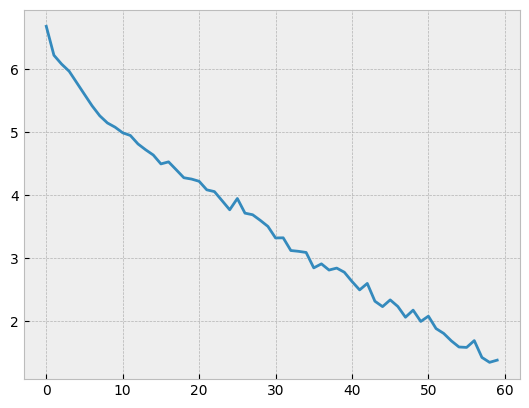

In [55]:
plt.figure()
plt.plot(all_losses)

### Zapis i odczyt sieci

#### Zapisanie sieci

In [56]:
# n_epochs=15

ALLTOKS, MODEL = ['all_tokens', 'model']
fn_pan_tadeusz = {ALLTOKS: f'all_tokens.n{n_tokens}.pan_tadeusz.p', 
                  MODEL: f'pan_tadeusz.h{hidden_size}.l{n_layers}.e{n_epochs}.gpu.torch'}
fn_dict = fn_pan_tadeusz; fn_dict

{'all_tokens': 'all_tokens.n5059.pan_tadeusz.p',
 'model': 'pan_tadeusz.h500.l3.e15.gpu.torch'}

In [0]:
# save all_tokens
all_tokens_path = tmp_path / fn_dict[ALLTOKS]
pickle.dump(all_tokens, open(all_tokens_path, 'wb'))

warnings.filterwarnings('ignore')

# save model
model_path = tmp_path / fn_dict[MODEL]
torch.save(decoder, model_path)

In [58]:
ls -lah $tmp_path

total 106M
drwxr-xr-x 2 root root 4.0K Nov 23 00:34 ./
drwxr-xr-x 3 root root 4.0K Nov 22 23:01 ../
-rw-r--r-- 1 root root  63K Nov 22 22:44 all_tokens.n4064.witkacy_szewcy.p
-rw-r--r-- 1 root root  80K Nov 23 00:34 all_tokens.n5059.pan_tadeusz.p
-rw-r--r-- 1 root root 5.4K Nov 23 00:32 e_syl.txt
-rw-r--r-- 1 root root  37M Nov 23 00:34 pan_tadeusz.h500.l3.e15.gpu.torch
-rw-r--r-- 1 root root  37M Nov 22 22:44 pan_tadeusz.h500.l3.e20.gpu.torch
-rw-r--r-- 1 root root   35 Nov 22 23:03 tmp_text_caps1.txt
-rw-r--r-- 1 root root   56 Nov 22 23:03 tmp_text_syl1.txt
-rw-r--r-- 1 root root  33M Nov 22 22:44 witkacy_szewcy.h500.l3.e11.gpu.torch


In [59]:
decoder.state_dict

<bound method Module.state_dict of RNN(
  (encoder): Embedding(5059, 500)
  (gru): GRU(500, 500, num_layers=3)
  (decoder): Linear(in_features=500, out_features=5059, bias=True)
)>

#### Załadowanie sieci

In [60]:
ls -lah $tmp_path

total 106M
drwxr-xr-x 2 root root 4.0K Nov 23 00:34 ./
drwxr-xr-x 3 root root 4.0K Nov 22 23:01 ../
-rw-r--r-- 1 root root  63K Nov 22 22:44 all_tokens.n4064.witkacy_szewcy.p
-rw-r--r-- 1 root root  80K Nov 23 00:34 all_tokens.n5059.pan_tadeusz.p
-rw-r--r-- 1 root root 5.4K Nov 23 00:32 e_syl.txt
-rw-r--r-- 1 root root  37M Nov 23 00:34 pan_tadeusz.h500.l3.e15.gpu.torch
-rw-r--r-- 1 root root  37M Nov 22 22:44 pan_tadeusz.h500.l3.e20.gpu.torch
-rw-r--r-- 1 root root   35 Nov 22 23:03 tmp_text_caps1.txt
-rw-r--r-- 1 root root   56 Nov 22 23:03 tmp_text_syl1.txt
-rw-r--r-- 1 root root  33M Nov 22 22:44 witkacy_szewcy.h500.l3.e11.gpu.torch


In [61]:
n_epochs=20
ALLTOKS, MODEL = ['all_tokens', 'model']
fn_pan_tadeusz = {ALLTOKS: f'all_tokens.n{n_tokens}.pan_tadeusz.p', 
                  MODEL: f'pan_tadeusz.h{hidden_size}.l{n_layers}.e{n_epochs}.gpu.torch'}
fn_dict = fn_pan_tadeusz; fn_dict

{'all_tokens': 'all_tokens.n5059.pan_tadeusz.p',
 'model': 'pan_tadeusz.h500.l3.e20.gpu.torch'}

In [62]:
if True:
  all_tokens_path = tmp_path / fn_dict[ALLTOKS]
  print(f'all_tokens_path = {all_tokens_path}')
  all_tokens = pickle.load(open(all_tokens_path, 'rb'))
  n_characters = len(all_tokens)
  tok2idx_dict = {tok: idx for (idx, tok) in enumerate(all_tokens)}

  model_path = tmp_path / fn_dict[MODEL]
  decoder = torch.load(model_path)
  decoder.gru.flatten_parameters()
  print(f'model_path = {model_path}')
  print(decoder.state_dict)

all_tokens_path = data/rnn_generator/tmp/all_tokens.n5059.pan_tadeusz.p
model_path = data/rnn_generator/tmp/pan_tadeusz.h500.l3.e20.gpu.torch
<bound method Module.state_dict of RNN(
  (encoder): Embedding(5059, 500)
  (gru): GRU(500, 500, num_layers=3)
  (decoder): Linear(in_features=500, out_features=5059, bias=True)
)>


## Ewaluacja w różnych "temperaturach"

W powyższej funkcji `evaluate`, za każdym razem, gdy dokonywana jest prognoza, wyjścia są dzielone przez przekazany argument "temperature". Użycie większej liczby sprawia, że wszystkie akcje są bardziej jednakowo prawdopodobne, a tym samym dają nam "bardziej losowe" wyniki. Użycie mniejszej wartości (mniejszej niż 1) sprawia, że wysokie prawdopodobieństwa przyczyniają się bardziej. Gdy ustawiamy temperaturę na zero, wybieramy tylko najbardziej prawdopodobne wyjścia.

Możemy zobaczyć te efekty poprzez dostosowanie argumentu `temperature`.


In [0]:
def print_eval(e_syl):
  display(HTML(format_html(fix_punctuation(decode_tokens(syl2str(e_syl, delim=''))))))

In [0]:
prime_tok = str2syl2tok('Litwo! Ojczyzno moja!')

In [65]:
print_eval(evaluate(prime_tok, 200, temperature=0.8))

Niższe temperatury daja mniejszą różnorodność, wybierając tylko bardziej prawdopodobne wyjścia:

In [66]:
print_eval(evaluate(prime_tok, 200, temperature=0.2))

Wyższe temperatury są bardziej różnorodne, wybierając mniej prawdopodobne wyjścia:

In [67]:
print_eval(evaluate(prime_tok, 200, temperature=1.4))

## Ćwiczenia

* Trenuj z własnym zestawem danych, np.
     * Tekst od innego autora
     * Posty na blogu
     * Kody źródłowe
* Zwiększ liczbę warstw i rozmiar sieci, aby uzyskać lepsze wyniki

**Następnie**: [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb)

## (debug) Monitorowanie maszyny wirtualnej

In [0]:
def print_memsize():
  process = psutil.Process(os.getpid())
  print(f'{process.memory_info().rss / 1024**3:.5} GB')

In [69]:
print_memsize()

2.3721 GB


In [70]:
!uptime

 00:35:33 up  2:06,  0 users,  load average: 0.18, 0.71, 0.91
